In [5]:
import json

import numpy as np
import pandas as pd
from bidict import bidict
from keras.src.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from models.instrument_first_models import ANN_One
from utils.config import IRMAS_MFCC_Config
from utils.instrument_data import IRMASDataManipulator

In [6]:
with open("../config.json") as json_data_file:
    general_config = json.load(json_data_file)

dataset_path = general_config["Philarmonia_Path_Alt"]

In [7]:
df = pd.read_csv("../statistics/philarmonia_complete_features.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,E:\LICENTA\Philarmonia_equalised\banjo\banjo_A...,66150,0.550151,0.091104,0.010619,0.000582,2654.644442,8.811590e+06,1800.021896,469451.299840,...,30.049957,4.657768,20.199316,6.173439,25.219570,7.408614,58.660255,7.386246,63.702087,banjo
1,E:\LICENTA\Philarmonia_equalised\banjo\banjo_A...,66150,0.489213,0.110880,0.009071,0.000290,2590.141390,8.375278e+06,1803.964797,522590.221199,...,25.184752,3.083776,18.426600,3.478706,13.153878,6.838226,48.252970,8.282816,101.449500,banjo
2,E:\LICENTA\Philarmonia_equalised\banjo\banjo_A...,66150,0.361614,0.106631,0.011336,0.000407,2643.877855,6.975677e+06,1973.605107,337811.744570,...,221.973770,22.752050,260.495640,20.600986,208.980580,5.801032,23.771830,-7.116735,56.795350,banjo
3,E:\LICENTA\Philarmonia_equalised\banjo\banjo_A...,66150,0.368762,0.110318,0.009076,0.000183,2758.357571,8.232753e+06,1830.125099,431004.256356,...,252.334610,31.159397,632.238600,22.469975,294.362120,5.274818,28.074590,-9.780495,107.969780,banjo
4,E:\LICENTA\Philarmonia_equalised\banjo\banjo_A...,66150,0.448844,0.131296,0.016890,0.001424,2467.369360,7.583936e+06,1767.599881,446391.394635,...,57.729847,8.311919,51.459473,12.830536,130.845170,2.742562,24.682962,-7.324739,241.220030,banjo


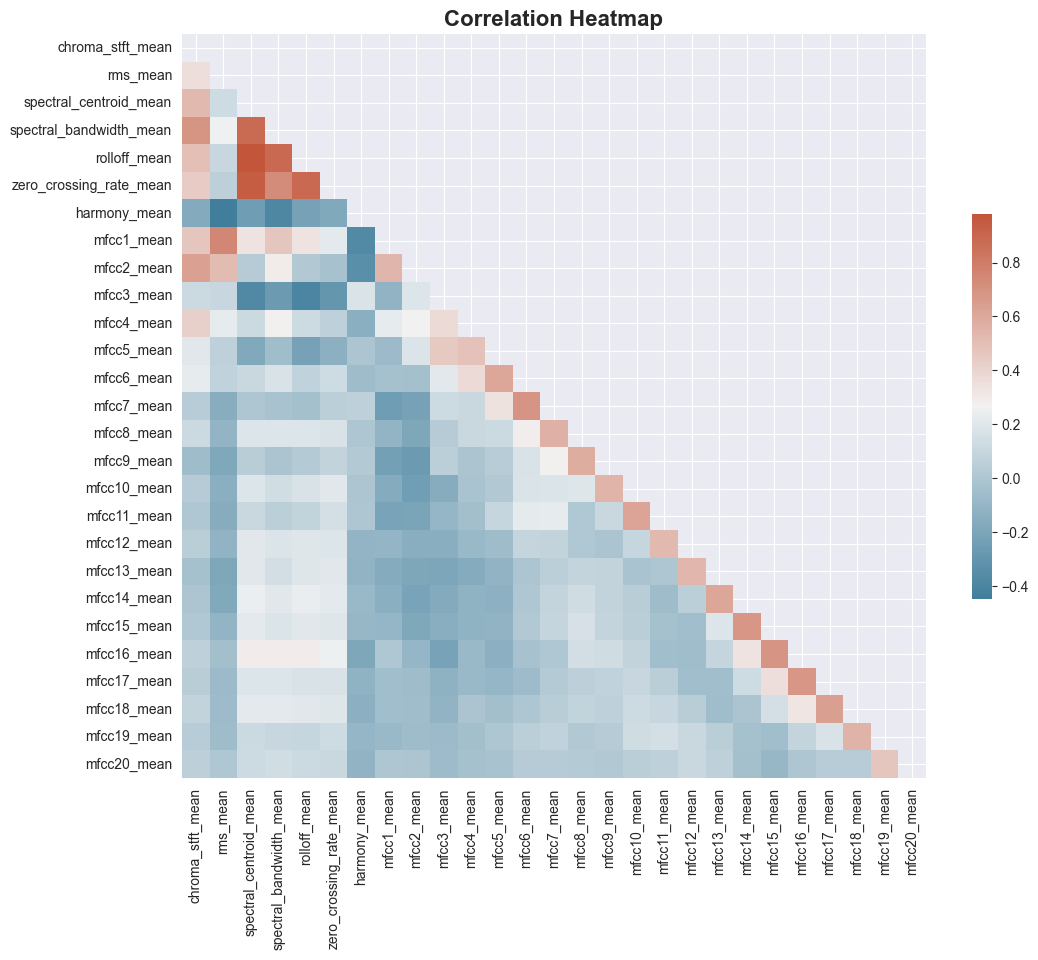

In [8]:
mean_columns = df.filter(regex='_mean$')

correlation_matrix = mean_columns.corr()

# Create a boolean mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=False, linewidths=0,
            cbar_kws={"shrink": .5}, square=True)

# Add a title to the heatmap
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

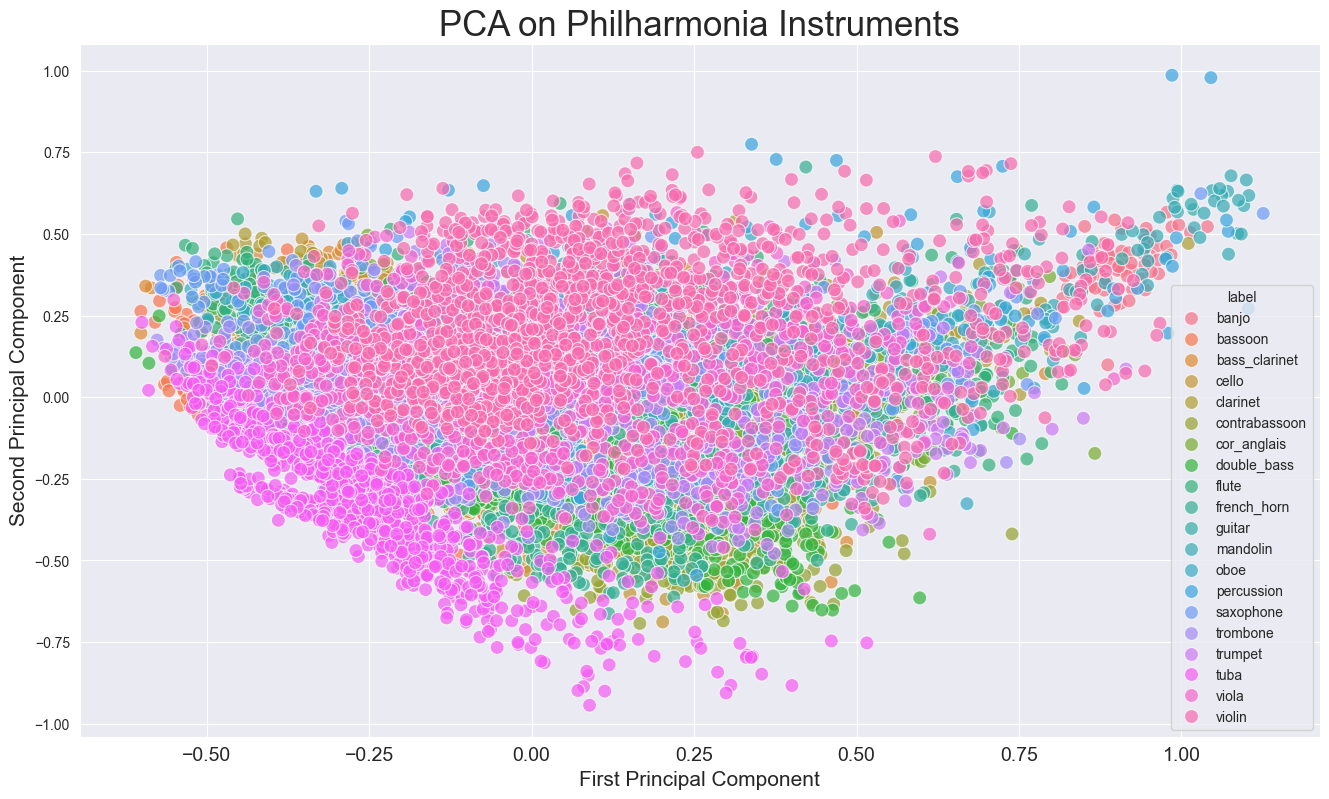

In [10]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']


#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Philharmonia Instruments', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("First Principal Component", fontsize = 15)
plt.ylabel("Second Principal Component", fontsize = 15)
plt.savefig("PCA Scattert_philarm.jpg")

## Creating pickle for 13x130 MFCC matrix to feed to ANN/CNN/RNN

In [6]:
CLASS_DICTIONARY = bidict({
    0 : "banjo",
    1 : "bassoon",
    2 : "bass_clarinet",
    3 : "cello",
    4 : "clarinet",
    5 : "contrabassoon",
    6 : "cor_anglais",
    7 : "double_bass",
    8 : "flute",
    9 : "french_horn",
    10 : "guitar",
    11 : "mandolin",
    12 : "oboe",
    13 : "percussion",
    14 : "saxophone",
    15 : "trombone",
    16 : "trumpet",
    17 : "tuba",
    18 : "viola",
    19 : "violin",
})

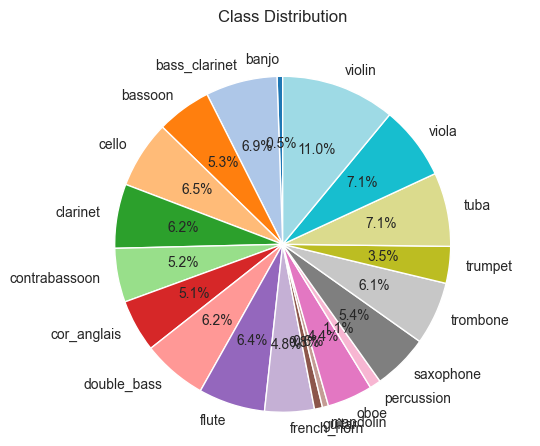

In [7]:
df = pd.read_csv('statistics/philarmonia_complete_features.csv')
df.set_index('filename', inplace=True)

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)

colors = plt.cm.tab20(np.arange(len(class_dist)) / len(class_dist))

ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

n_samples = 2 * int(df['length'].sum()/0.1) # a tenth of a second

prob_dist = class_dist / class_dist.sum() # probability distribution of each instrument being picked